In [2]:
!pip install inception

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 5.2 MB/s 
  Created wheel for inception: filename=inception-0.0.3-py3-none-any.whl size=6879 sha256=ead7aa0b007ad3b671c1b6f0481a8e5b65fb19fbd31b618305350d18bf7bdeda
  Stored in directory: /root/.cache/pip/wheels/f5/53/30/fe2172262b53ab331af29fdd82b649b884dc2fd4e2c3225a91
Successfully built inception


In [3]:
!pip install -q git+https://github.com/tensorflow/docs

In [4]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

In [5]:

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import imageio
import cv2
import os
import pandas as pd

# Functions and classes for loading and using the Inception model.

from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow_docs.vis import embed
from imutils import paths


In [6]:
# example of loading the inception v3 model
from keras.applications.inception_v3 import InceptionV3
# load model
model = InceptionV3()
# summarize the model
model.summary()

96112376/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [7]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [8]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
403,v_ShavingBeard_g15_c02.avi,ShavingBeard
471,v_ShavingBeard_g25_c01.avi,ShavingBeard
406,v_ShavingBeard_g15_c05.avi,ShavingBeard
344,v_Punch_g23_c07.avi,Punch
476,v_ShavingBeard_g25_c06.avi,ShavingBeard
454,v_ShavingBeard_g22_c05.avi,ShavingBeard
137,v_PlayingCello_g10_c07.avi,PlayingCello
390,v_ShavingBeard_g13_c01.avi,ShavingBeard
1,v_CricketShot_g08_c02.avi,CricketShot
447,v_ShavingBeard_g21_c05.avi,ShavingBeard


In [9]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


In [10]:

def classify(image_path):
    # Display the image.
    display(Image(image_path))

    # Use the Inception model to classify the image.
    pred = model.classify(image_path=image_path)

    # Print the scores and names for the top-10 predictions.
    model.print_scores(pred=pred, k=10, only_first_name=True)

In [11]:


def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 1s 0us/step


In [12]:

label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [14]:


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 172ms/step
Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


In [19]:

# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

   
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

tf.keras.models.save_model(sequence_model,'my_model.hdf5') 

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 1.3923 - accuracy: 0.3687
Epoch 1: val_loss improved from inf to 2.41033, saving model to /tmp/video_classifier
13/13 [==============================] - 10s 268ms/step - loss: 1.3923 - accuracy: 0.3687 - val_loss: 2.4103 - val_accuracy: 0.0279
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.0939 - accuracy: 0.5976
Epoch 2: val_loss did not improve from 2.41033
13/13 [==============================] - 1s 48ms/step - loss: 1.0939 - accuracy: 0.5976 - val_loss: 2.5090 - val_accuracy: 0.0894
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 0.9639 - accuracy: 0.7229
Epoch 3: val_loss did not improve from 2.41033
13/13 [==============================] - 1s 47ms/step - loss: 0.9639 - accuracy: 0.7229 - val_loss: 2.7438 - val_accuracy: 0.2905
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 0.8437 - accuracy: 0.7398
Epoch 4: val_loss did not improve from 2.41033
13/13

Test video path: v_TennisSwing_g07_c01.avi
1/1 [==============================] - 3s 3s/step
  Punch: 32.76%
  CricketShot: 28.54%
  ShavingBeard: 24.32%
  PlayingCello:  7.27%
  TennisSwing:  7.10%



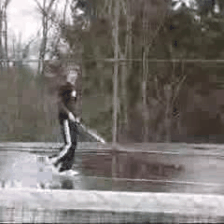

In [17]:


def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
model.save(model.hdf5)